### General libs to import

In [52]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import openmesh
from supporting_circles import Circle
from iterative_shift import show_mesh_with_all_found_axes
from symmetry_test import parse_axis_perturbation_file
from transformations import rad_to_degree, linear_range_map

# Results for objects with known symmetries

### About the csv files

The results are stored in the folders `results/axis` in csv files such as `meshx_man_sim.csv` and `meshx_rand_man_sim.csv`, with x being the number of the mesh. This was currently tested with bodies 1,2,4,5,6 and 7. 

Each file contains the following fields
 - iteration: number of iterations taken to reach the final result
 - loss: the loss meassured using chamfer distance over the input mesh and the best symmetry axis found
 - normal x, normal y, normal z: x, y and z coordinates of best symmetry axis found (normalized) 
 - angle diff: the angle meassured between the found axis and the original axis, in rads
 - timestamp: when the test was run. Format YYYY-DD-MM_HH_mm_ss
 - desviacion: perturbation of initial given axis against the original axis, in degrees

The following fields corresponds to parameters given by the user when running the tests

- delta radius: initial radius of the circle at the tip of the initial axis to spawn random candidates
- decrease factor: factor at which the delta radius decreases when a better candidate is not found at a given iteration. Multiplicative
- phi simmetries: number of candidates to try per iteration
- epsilon radius: minimum radius attained to stop the program
- chi convergence: minimum convergence (difference between losses) by the power of two that stops the program
- n sample points: points to uniformly sample from each mesh
- n angles: number of uniform angle sections to calculate chamfer distance, based on mesh rotations

In [24]:
def get_cmap(n, name='hsv'):
    """
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.
    reference: https://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.pdf
    """
    #return plt.cm.get_cmap(name, n)
    return plt.colormaps[name].resampled(n)

In [25]:
def apply_filters(dataframe, filter_dict):
    filtered = dataframe
    
    for filter in filter_dict:
        filtered = filtered.loc[getattr(dataframe[filter["col"]], filter["op"])(filter["val"])]

    return filtered

In [26]:
def errorbar_two_y_axes(ax, 
                        x_arr, 
                        y_data,
                        err_data,
                        y_colnames,
                        x_label=None,
                        y_labels=[],
                        title=None):
    m = len(y_colnames)
    cmap = get_cmap(m + 1, "brg")
    lines = []
    if x_label is None:
        x_label = ""
    if title is None:
        title = ""
    for j in range(m):
        col = y_colnames[j]
        if len(y_labels) == 0 or y_labels[j] is None:
            y_label = col
        else: 
            y_label = y_labels[j]
        if j != 0:
            ax_twin = ax.twinx()
        else:
            ax_twin = ax
            # source:
            # https://stackoverflow.com/questions/58009069/how-to-avoid-overlapping-error-bars-in-matplotlib
        lines.append(ax_twin.errorbar(x_arr,
                                      y_data[col],
                                      err_data[col],
                                      label=y_label,
                                      color=cmap(j),
                                      alpha=.85,
                                      fmt=':',
                                      capsize=3,
                                      capthick=1))
        ax_twin.set_ylabel(y_label)
        ax_twin.fill_between(x_arr,
                             y_data[col]-err_data[col],
                             y_data[col]+err_data[col],
                             color=cmap(j),
                             alpha=.25)
    labs = [l.get_label() for l in lines]
    ax.set_xlabel(x_label)
    ax.legend(lines, labs, loc=0)
    # fig.tight_layout()
    plt.title(title)

In [27]:
def calc_mean_std(dataframe, 
                  filter_dict, 
                  grouping_col,
                  y_colnames):
    filtered_i = apply_filters(dataframe, filter_dict)  
    grouped = filtered_i.groupby(grouping_col, as_index=False)
    mean_i = grouped.mean(numeric_only=True)
    x = mean_i[grouping_col]
    mean_i = mean_i[y_colnames]
    std_i = grouped.std(numeric_only=True)[y_colnames]
    
    return x, mean_i, std_i

In [107]:
def plot_means(dataframe, 
               filter_dict, 
               grouping_col,
               ax,
               y_colnames,
               title=None):
    x, mean_i, std_i = calc_mean_std(dataframe, 
                                     filter_dict, 
                                     grouping_col,
                                     y_colnames)
    # TODO: implementar una solución más elegante
    if grouping_col == "desviacion":
        xlabel = "desviación"
    else:
        xlabel = grouping_col
    # https://stackoverflow.com/questions/62177520/how-to-add-error-bars-in-matplotlib-for-multiple-groups-from-dataframe
    errorbar_two_y_axes(ax, 
                        x,
                        mean_i,
                        std_i,
                        y_colnames,
                        xlabel,
                        y_colnames,
                        title)

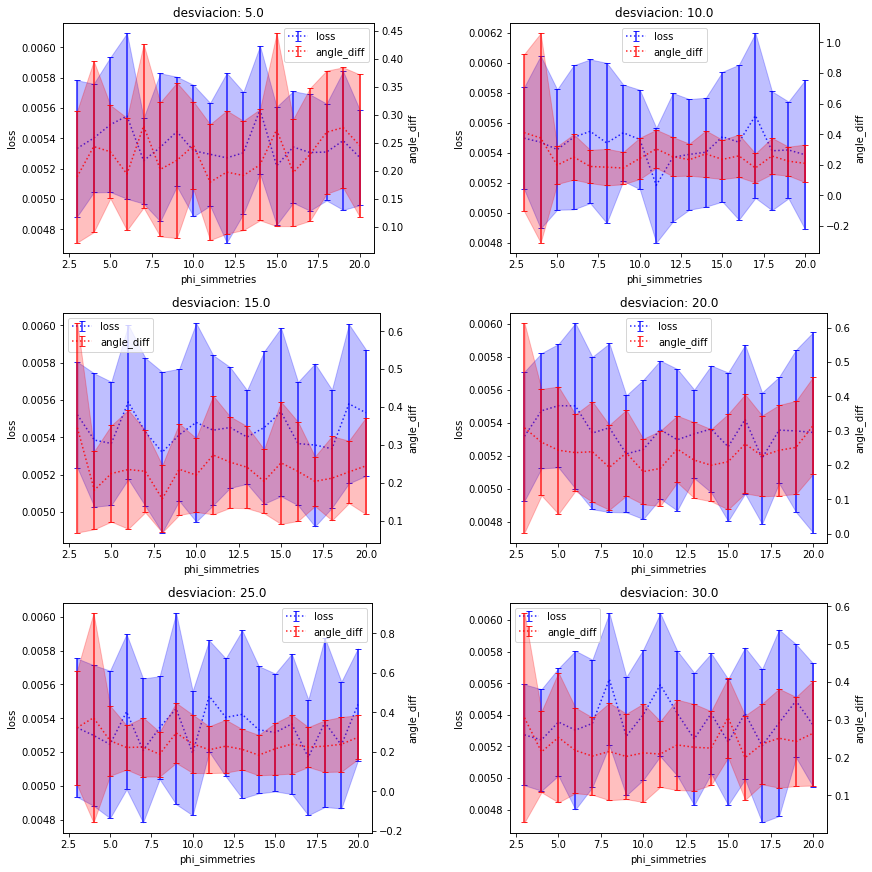

In [108]:
    num_csv = 6
    file_name = "mesh{}_rand_man_sim.csv".format(num_csv)
    
    pd_res = pd.read_csv(os.path.join("results", "axis", file_name))
    pd_res["angle_diff"] = rad_to_degree(pd_res["angle_diff"])

    filters = [
        {
            "col": "chi_convergence",
            "op": "__eq__",
            "val": 0.0001
        },
        {
            "col": "n_angles",
            "op": "__eq__",
            "val": 6
        },
        {
            "col": "phi_simmetries",
            "op": "__gt__",
            "val": 2
        },
    ]
    
    col_groups = ["desviacion", "phi_simmetries"]
    shown_y_columns = ["loss", "angle_diff"]
  
    filtered = apply_filters(pd_res, filters)

    indices = filtered[col_groups[0]].unique()
    len_inds = len(indices)
    
    fig = plt.figure(layout='constrained', figsize=(12, 12))
    subfigs = fig.subfigures((len_inds+1)//2, 2, wspace=0.07)
    
    for k in range(len(indices)):
        i = indices[k]
        ax1 = subfigs[k//2][k%2].subplots()
        filters_i = [
            {
                "col": col_groups[0],
                "op": "__eq__",
                "val": i
            }
        ]
        plot_means(
            filtered, 
            filters_i, 
            col_groups[1],
            ax1,
            shown_y_columns,
            title="{}: {}".format(col_groups[0], i))
       
    plt.show()

In [109]:
class TestType:
    phi_symmetries = "phi"
    n_angles = "n_angles"
    desviacion = "desviacion"

def show_known_syms(test_type: TestType):
    num_csvs = [1, 2, 4, 5, 6, 7]
    len_csvs = len(num_csvs)
    im_file_base = "0{}_{}.png"


    if test_type == TestType.phi_symmetries:
        filters = [
            {
                "col": "chi_convergence",
                "op": "__eq__",
                "val": 0.0001
            },
            {
                "col": "n_angles",
                "op": "__eq__",
                "val": 6
            },
            {
                "col": "phi_simmetries",
                "op": "__gt__",
                "val": 2
            },
            {
                "col": "desviacion",
                "op": "__eq__",
                "val": 15
            }
        ]
        groups = ["phi_simmetries"]
        suf = "phi"

    elif test_type == TestType.n_angles:
        filters = [
            {
                "col": "chi_convergence",
                "op": "__eq__",
                "val": 0.0001
            },
            {
                "col": "n_angles",
                "op": "__gt__",
                "val": 1
            },
            {
                "col": "phi_simmetries",
                "op": "__eq__",
                "val": 16
            },
            {
                "col": "desviacion",
                "op": "__eq__",
                "val": 15
            }
        ]
        groups = ["n_angles"]
        suf = "loss"
    elif test_type == TestType.desviacion:
        filters = [
            {
                "col": "chi_convergence",
                "op": "__eq__",
                "val": 0.0001
            },
            {
                "col": "n_angles",
                "op": "__eq__",
                "val": 6
            },
            {
                "col": "phi_simmetries",
                "op": "__eq__",
                "val": 16
            }
        ]
        groups = ["desviacion"]
        suf = "desv"
        
    fig = plt.figure(layout='constrained', figsize=(16, 12), dpi=200)
    subfigs = fig.subfigures((len_csvs+1)//2, 2, wspace=0.2)

    shown_y_columns = ["loss", "angle_diff"]
    for k in range(len_csvs):
        num_csv = num_csvs[k]
        file_name = "mesh{}_rand_man_sim.csv".format(num_csv)
        
        im_file = im_file_base.format(num_csv, suf)
        im_path = os.path.join("results", "ps", "known_symmetry", im_file)

        pd_res = pd.read_csv(os.path.join("results", "axis", file_name))
        pd_res["angle_diff"] = rad_to_degree(pd_res["angle_diff"])

        pd_filtered = apply_filters(pd_res, filters)

        group_by = pd_filtered.groupby(groups)

        
        mean_i = group_by.mean(numeric_only=True)[["normal_x", "normal_y", "normal_z"]]
        x = mean_i.index.get_level_values(0)
        std_i = group_by.std(numeric_only=True)

        std_ang = std_i["angle_diff"].to_numpy()
        
        subfigs[k//2][k%2].suptitle("{}".format(file_name))
        subfigs[k//2][k%2].set_facecolor(color='0.95')
        subsubfigs = subfigs[k//2][k%2].subfigures(1, 2, width_ratios=[2,1])
        #ax1 = subfigs[k//2][k%2].subplots()
        ax1 = subsubfigs[0].subplots()

        plot_means(
            pd_res, 
            filters, 
            groups[0],
            ax1,
            shown_y_columns)
        
        image = mpimg.imread(im_path)
        ax_im = subsubfigs[1].subplots()
        
        ax_im.imshow(image)
        ax_im.axis('off')

    plt.show()

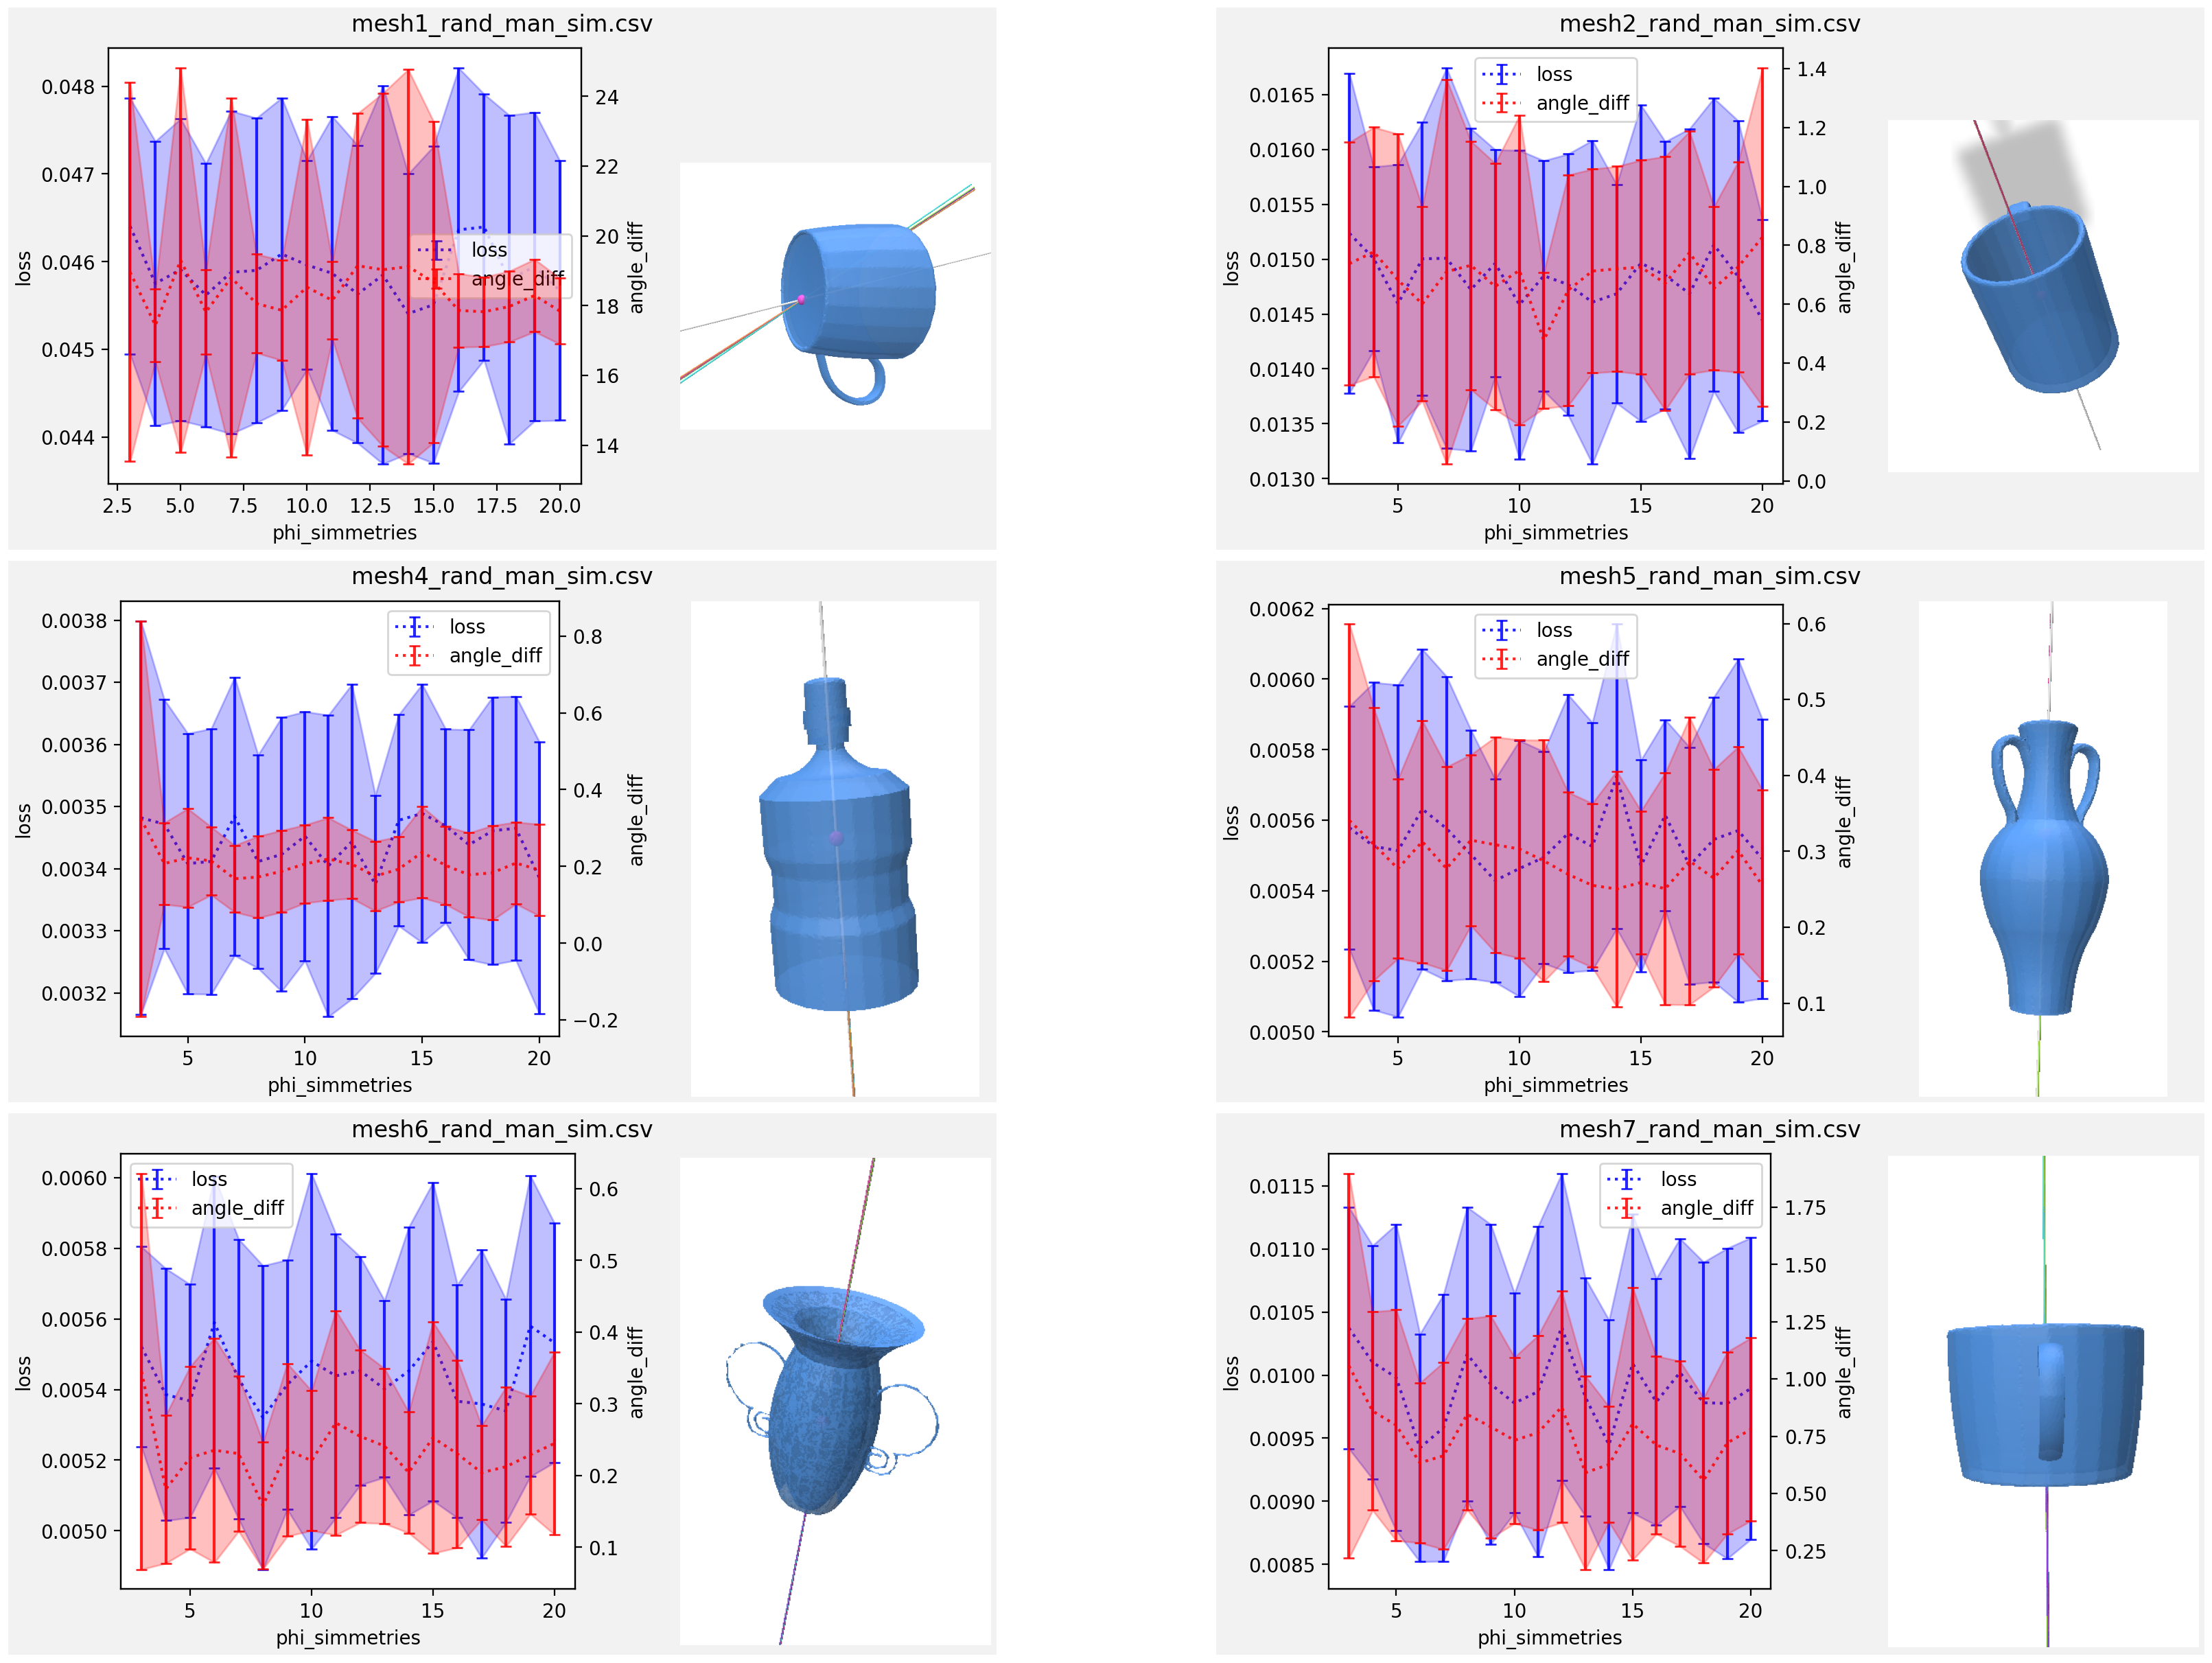

In [110]:
show_known_syms(TestType.phi_symmetries)

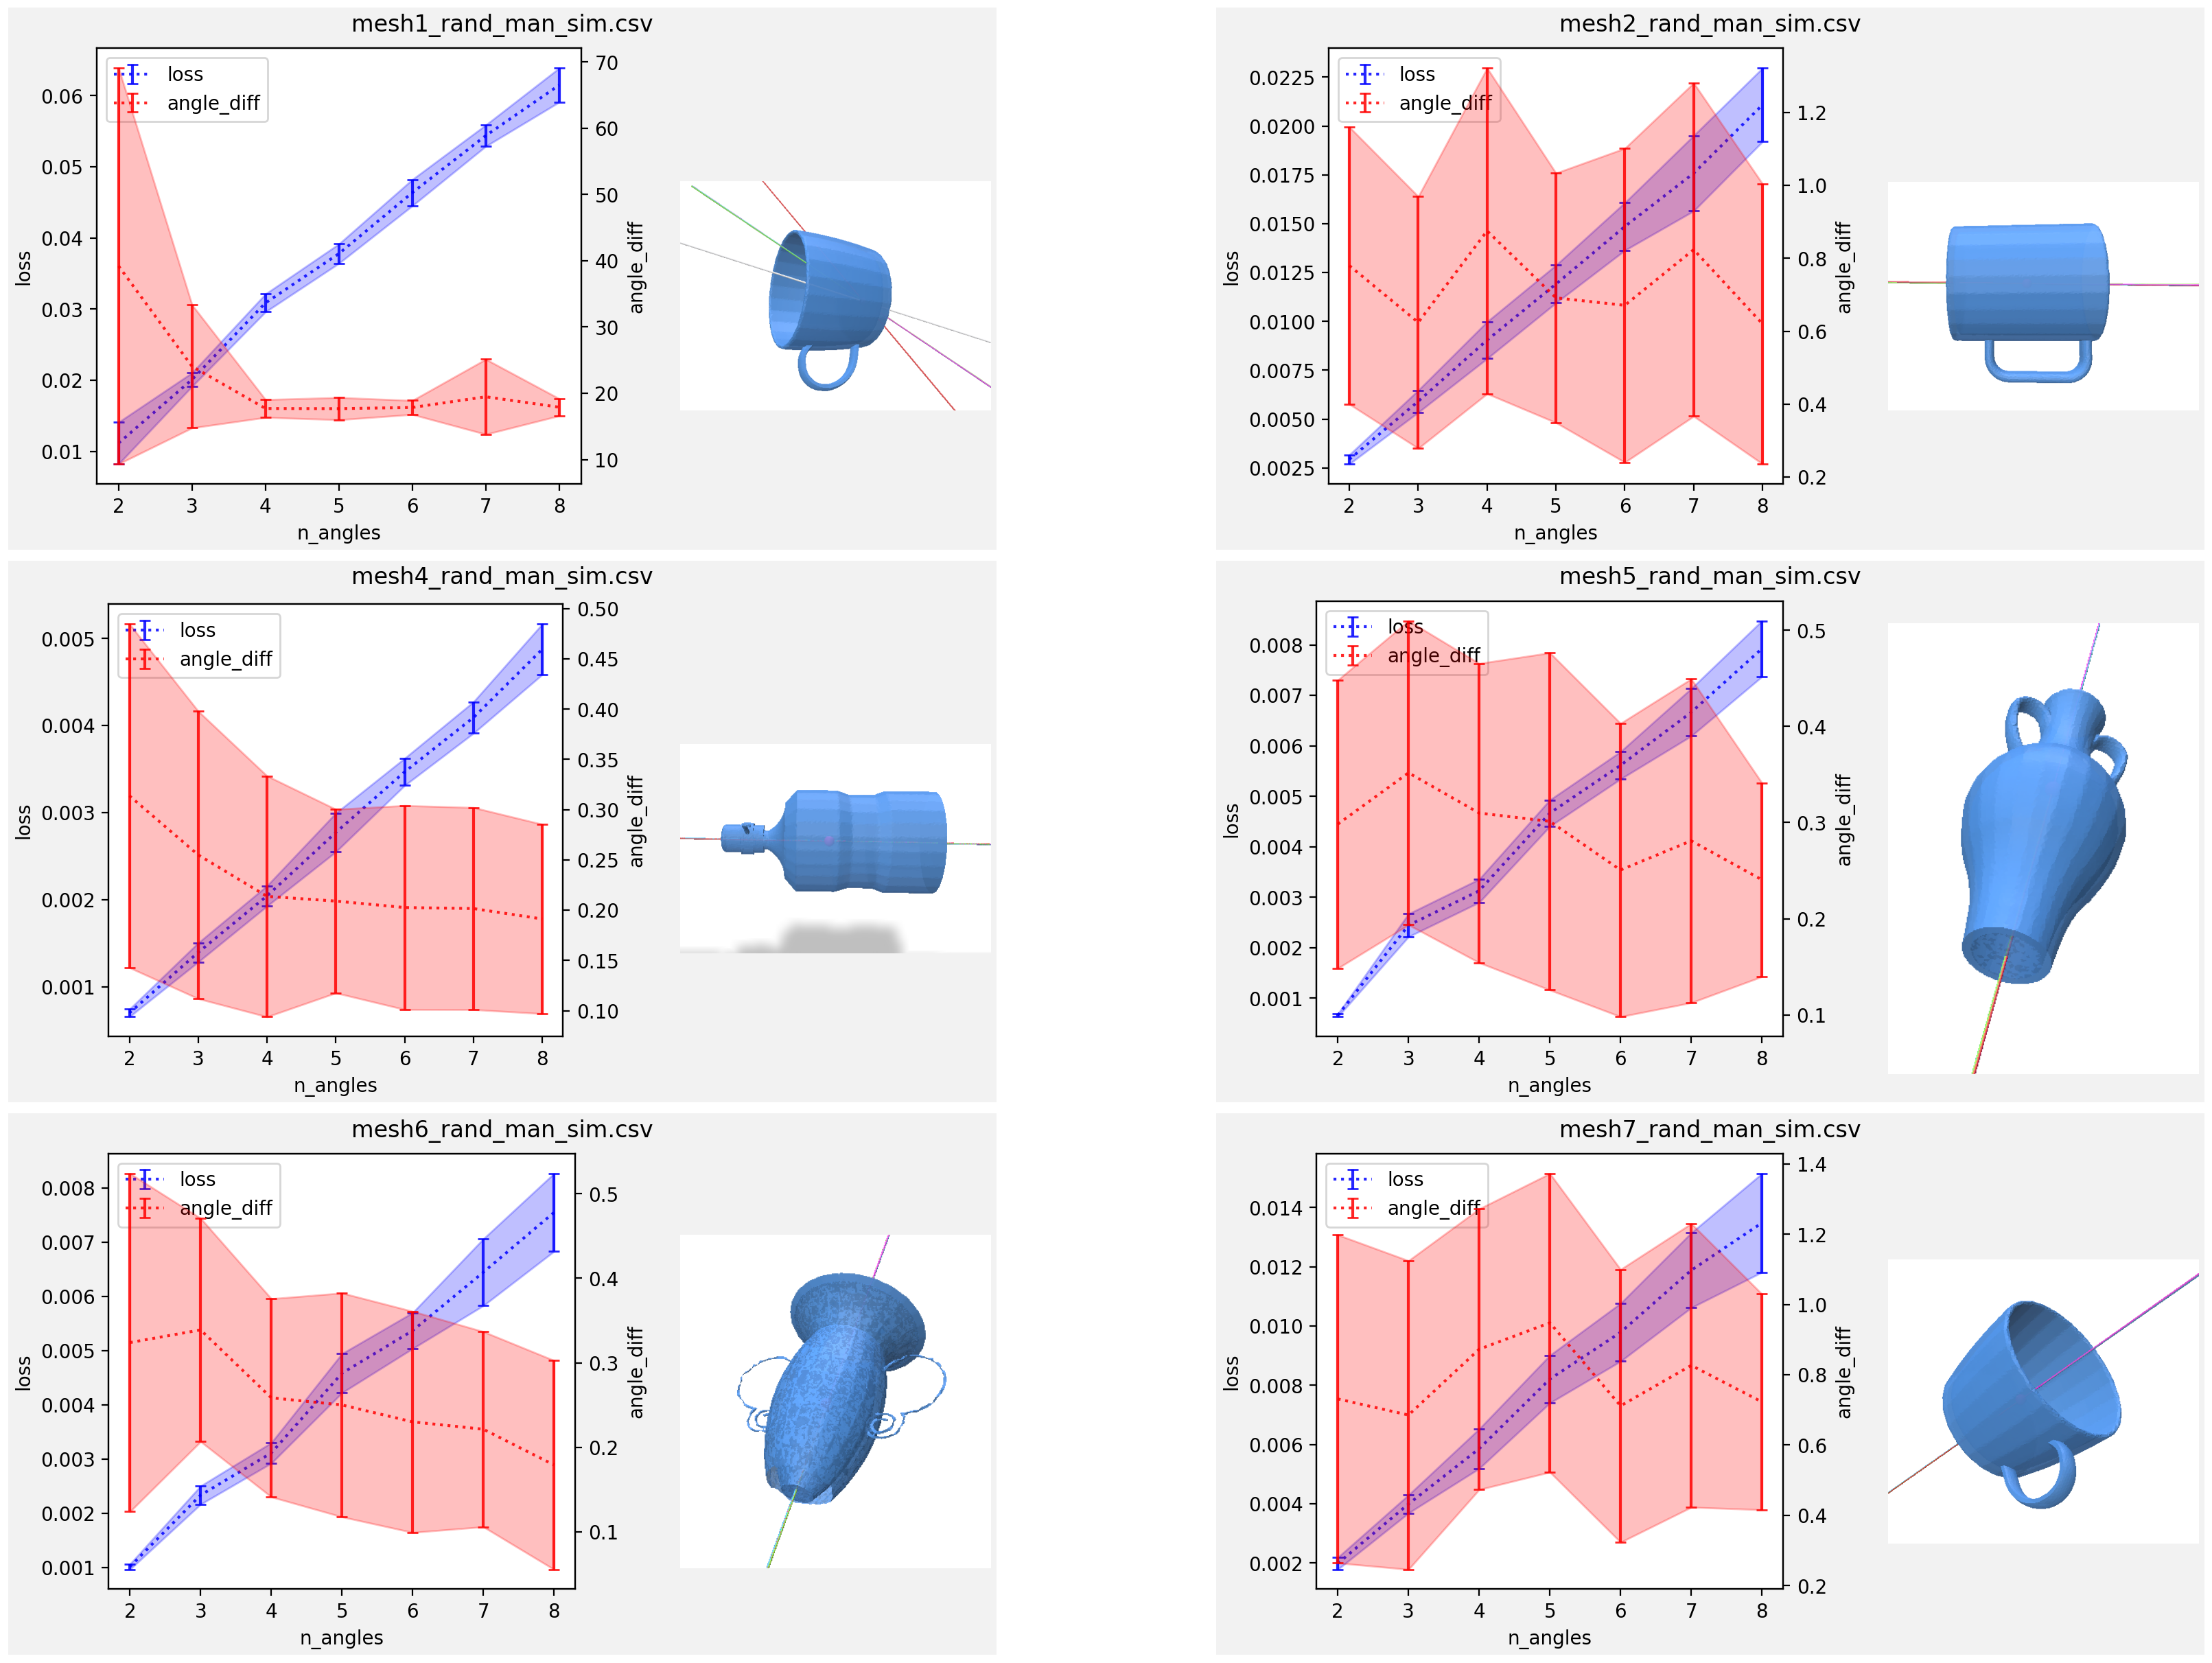

In [111]:
show_known_syms(TestType.n_angles)

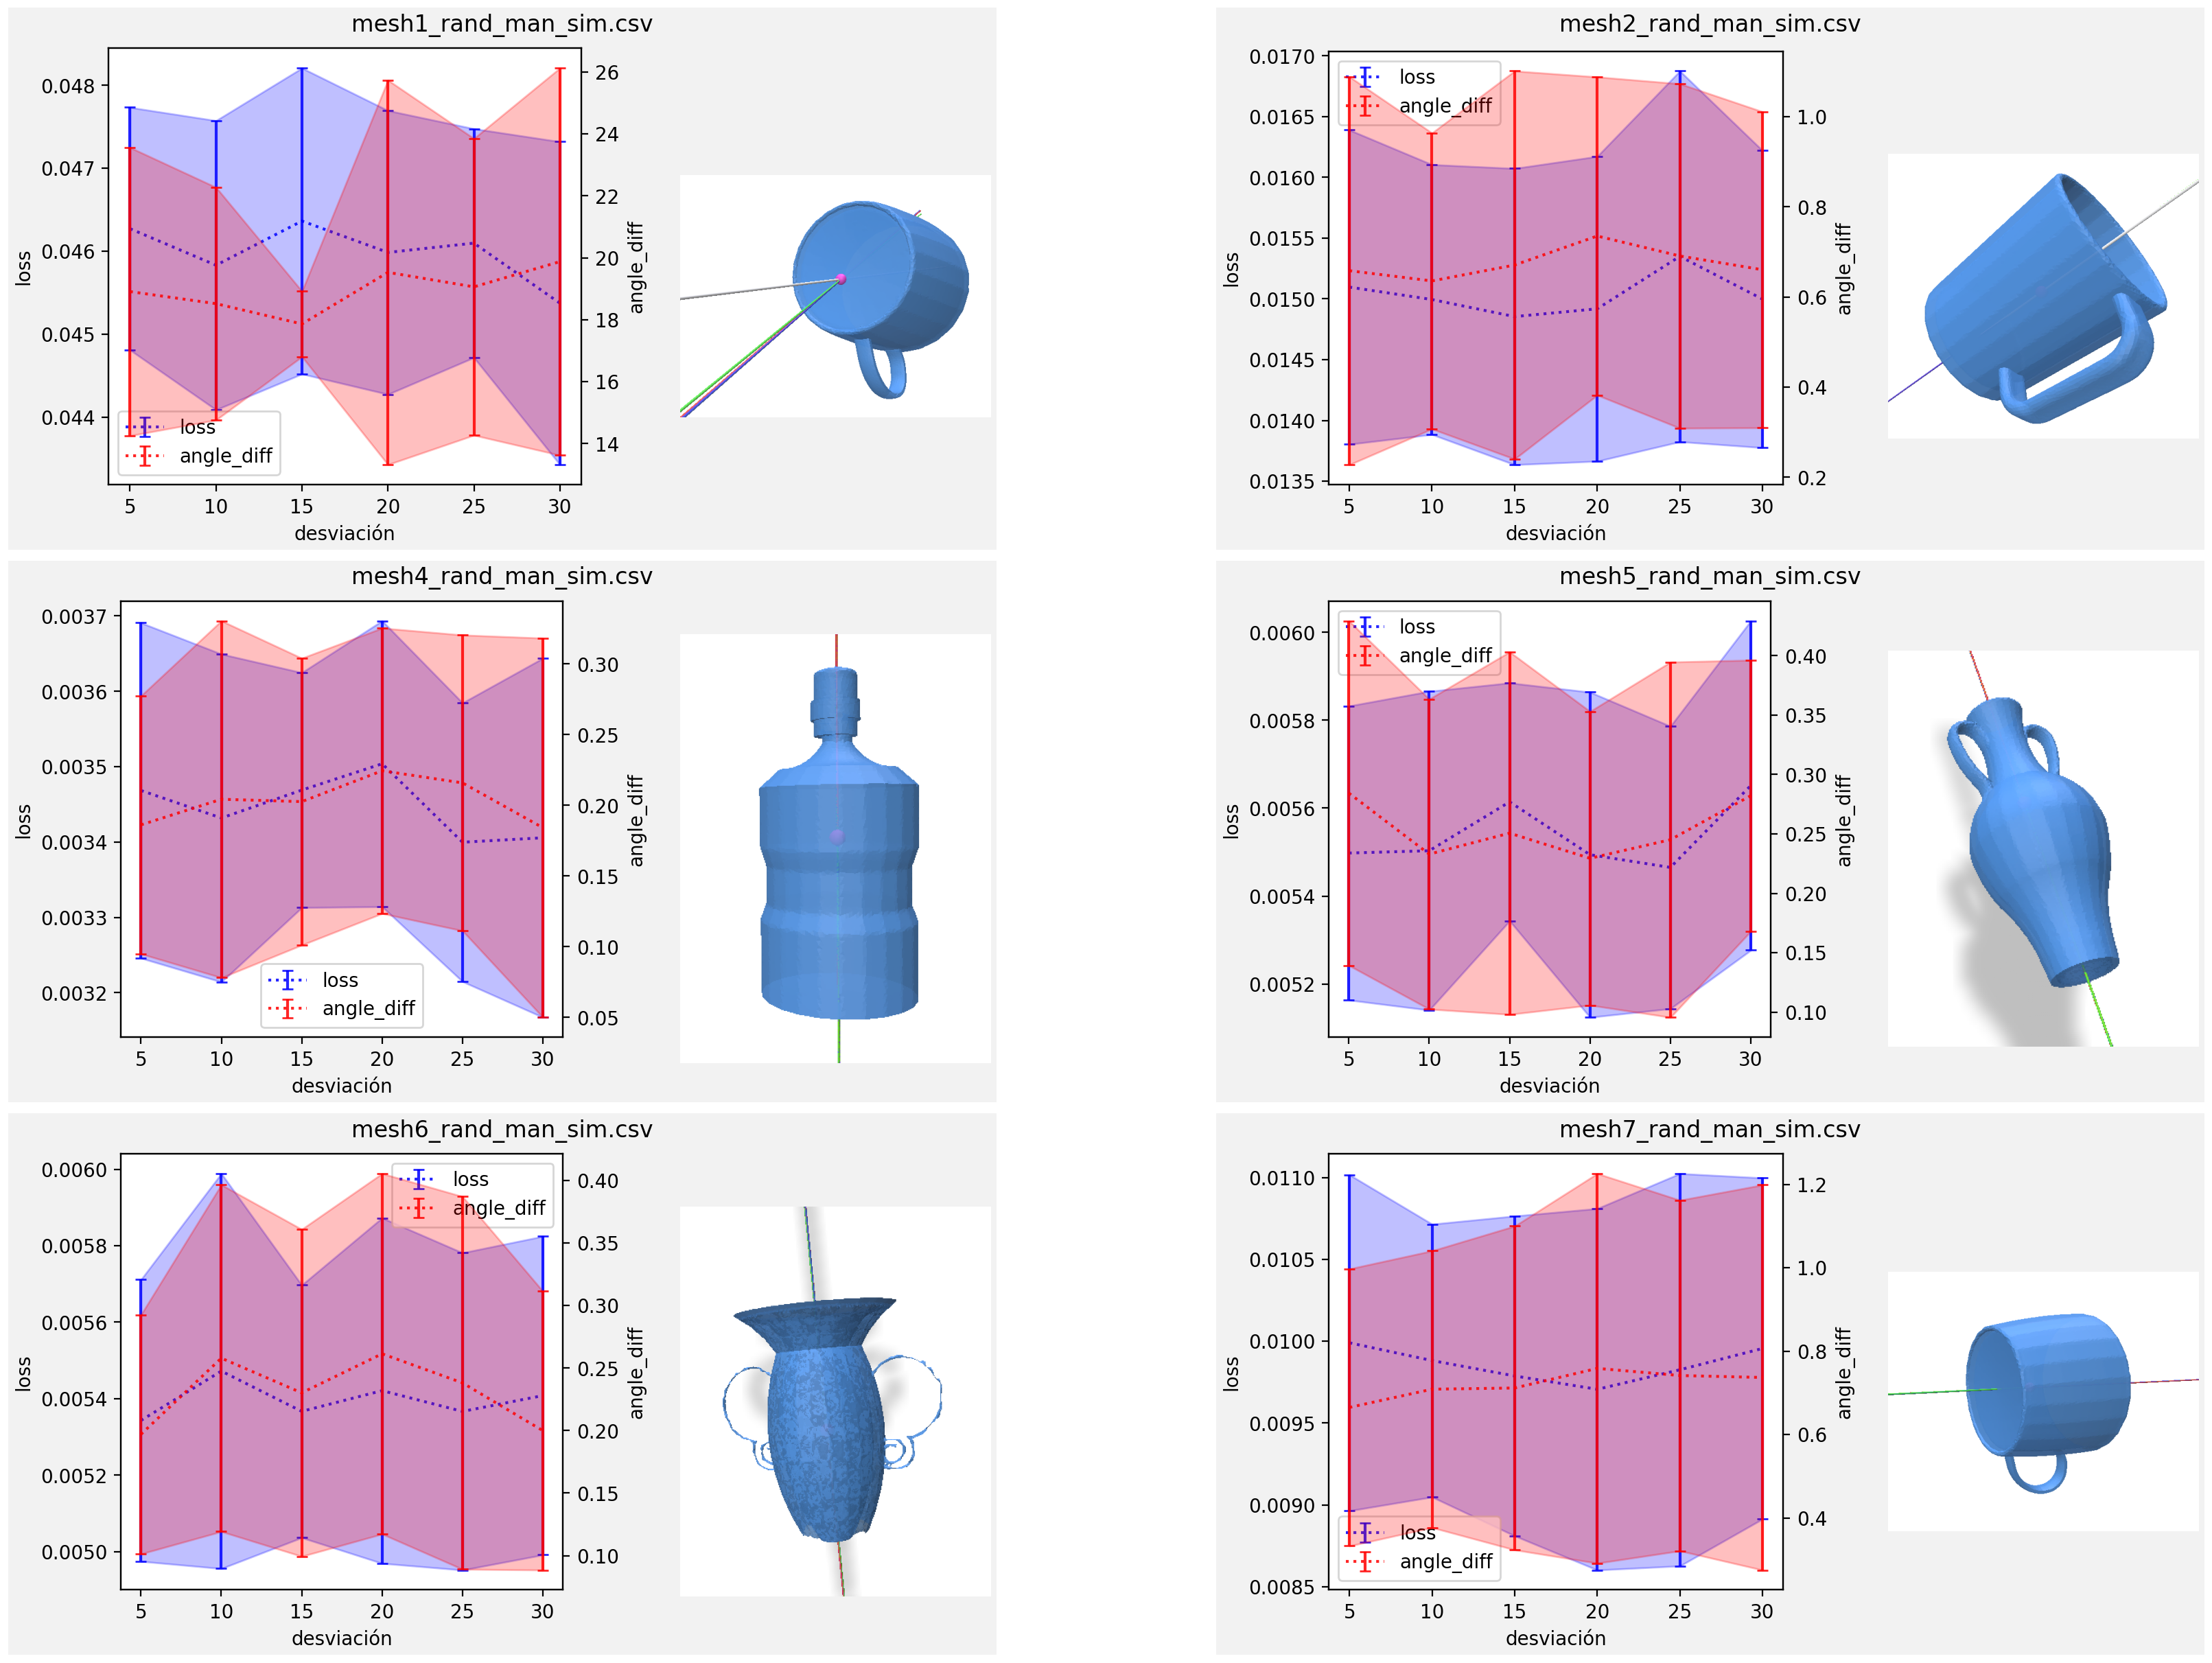

In [112]:
show_known_syms(TestType.desviacion)

# Results for dataset objects

These are the results of applying this algorithm over the set of figures Larco. The initial symmetry is obtained using the partial symmetry script in this repository.

In [17]:
def add_desviacion(dataframe):
    sample_group = dataframe.groupby("timestamp")
    first_per_sample = sample_group.nth(0)

    n_rows = dataframe.shape[0]

    dataframe["desviacion"] = np.ones(n_rows)

    degrees = np.arctan(first_per_sample["delta_radius"])*180/np.pi
    timestamps = list(first_per_sample.index)

    for i in range(len(timestamps)):
        timestamp = timestamps[i]
        degree = degrees[i]
        n_affected_rows = dataframe.loc[dataframe["timestamp"] == timestamp, "desviacion"].shape[0]

        dataframe.loc[dataframe["timestamp"] == timestamp, "desviacion"] = np.ones(n_affected_rows)*degree
    return dataframe

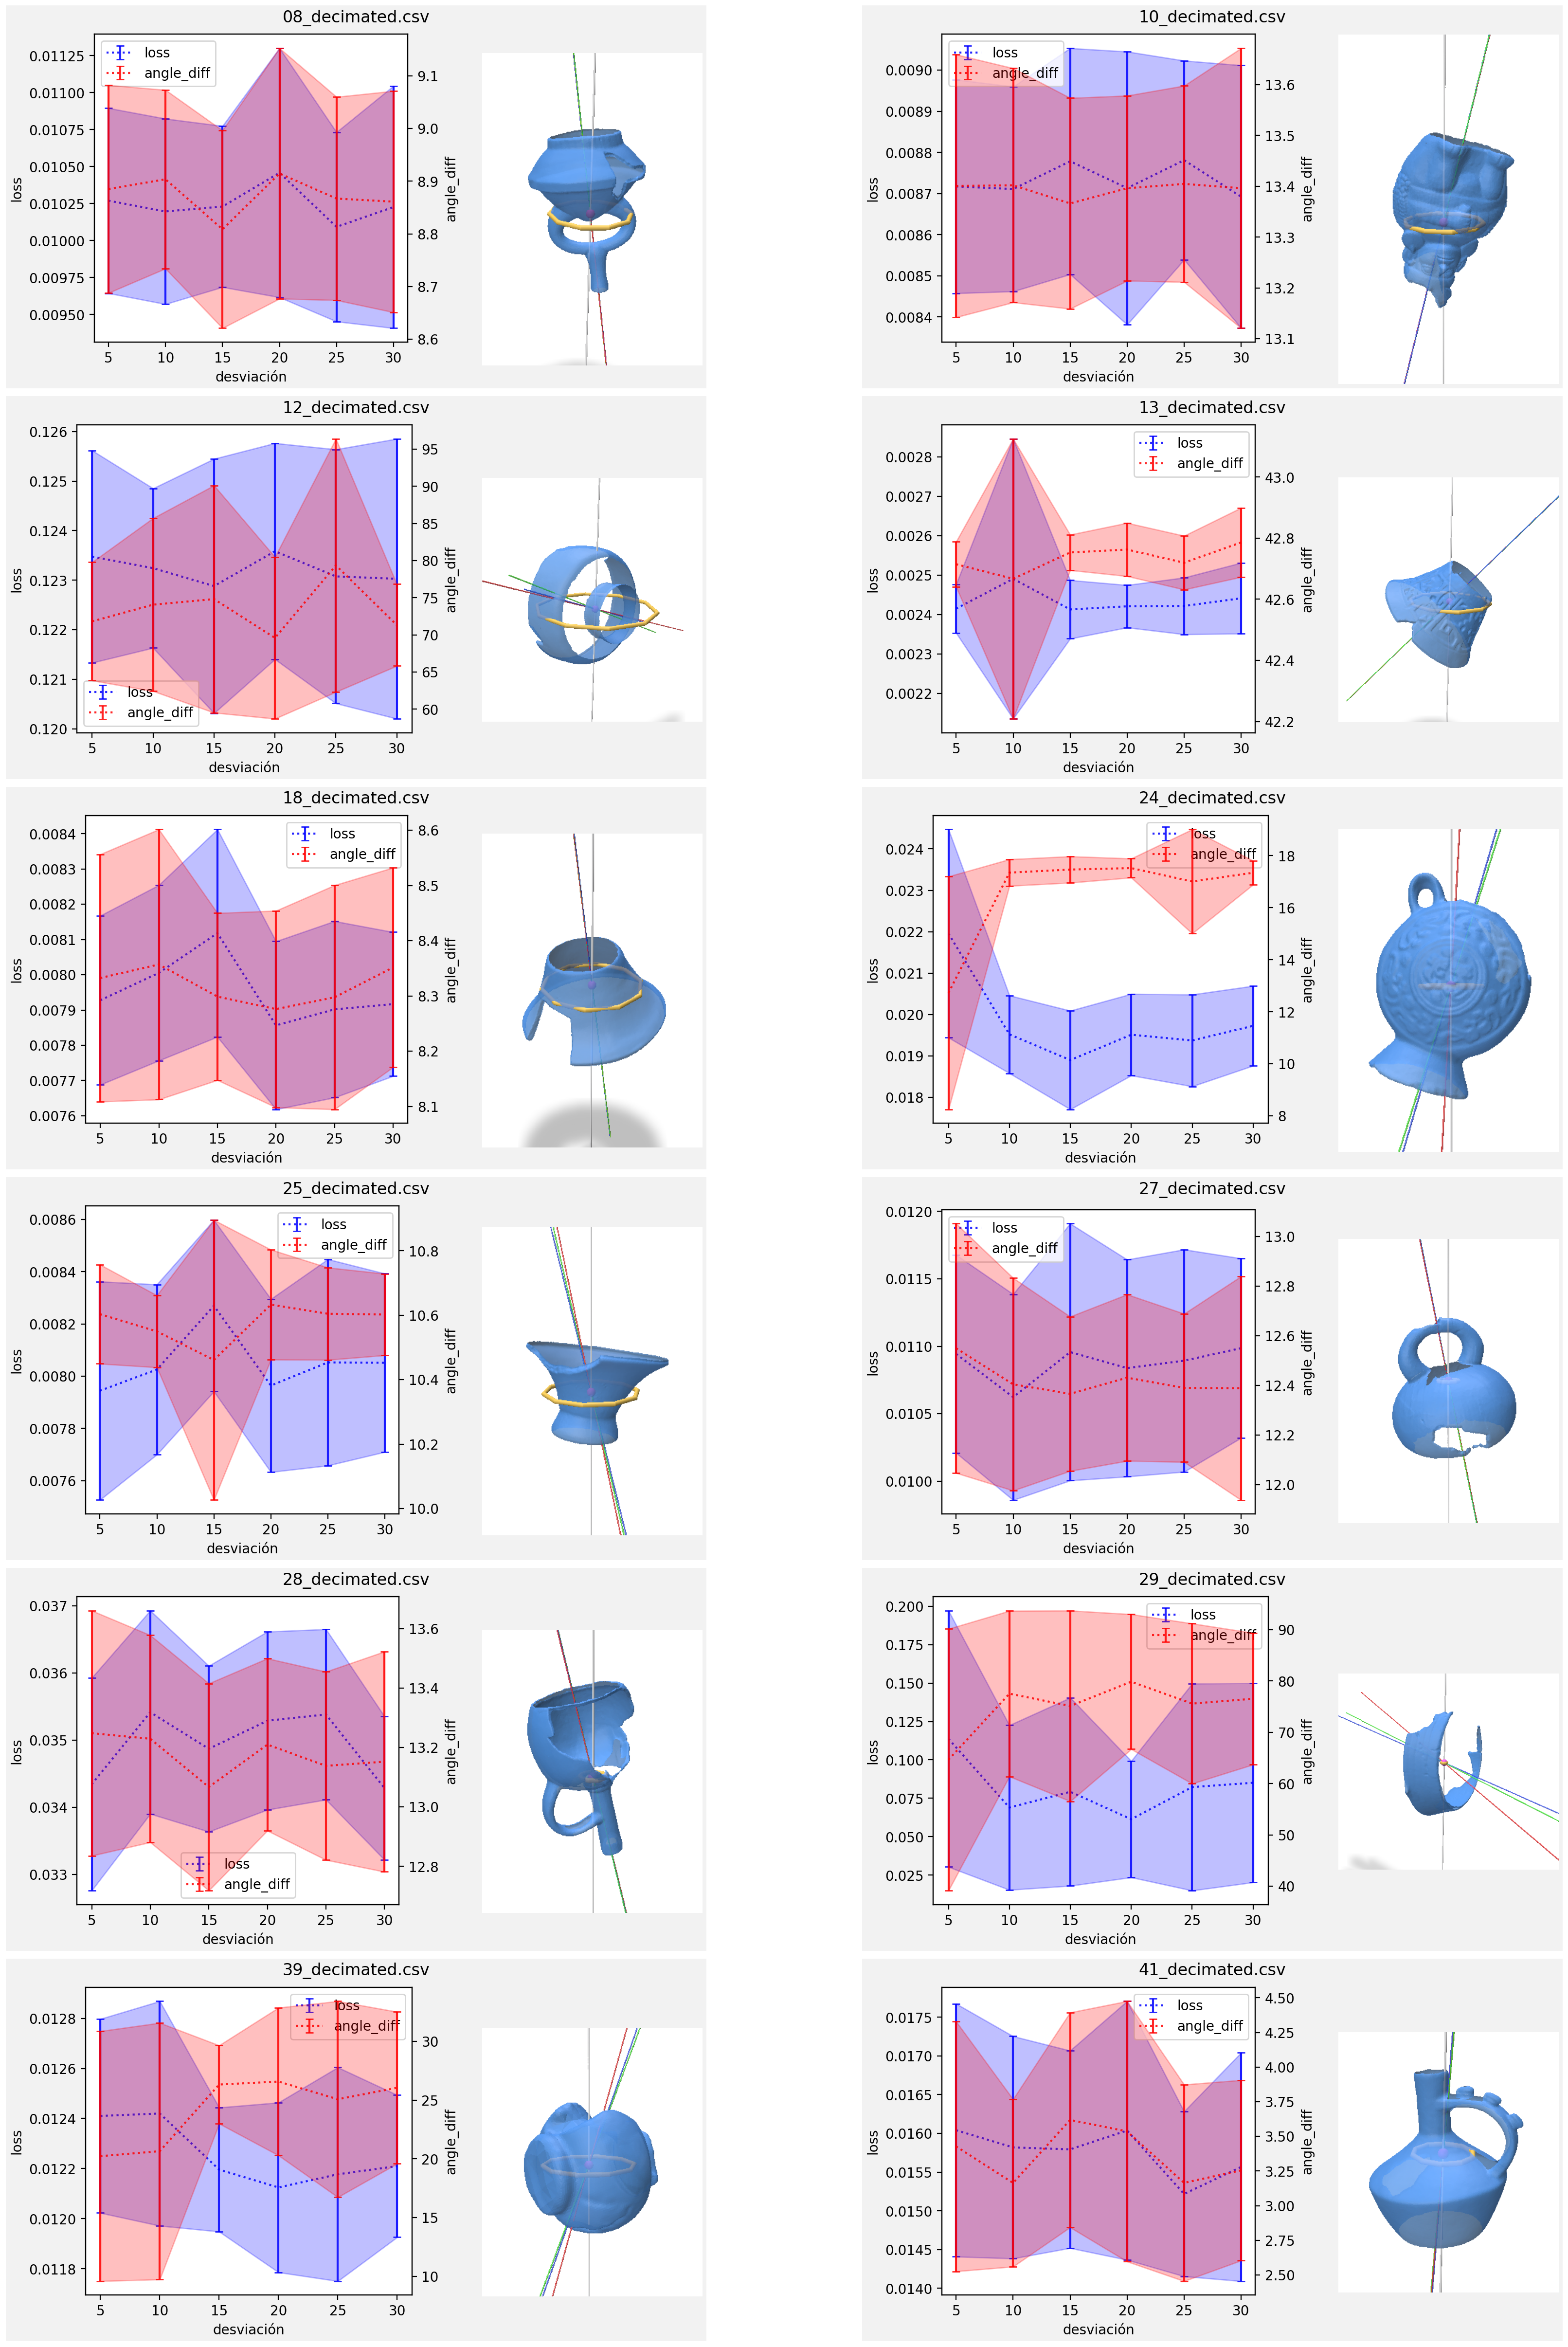

In [129]:
num_csv = 1
file_name = "{}_decimated.csv".format(str(num_csv).zfill(2))

decimated = os.listdir(os.path.join("results", "axis"))
decimated = [f for f in decimated if "decimated.csv" in f]
decimated = [f for f in decimated if sum([n in f for n in ["08", "10", "12", "13", "18", "24", "25", "27", "28", "29", "39", "41"]])]

n_files = len(decimated)

fig = plt.figure(layout='constrained', figsize=(16, 24), dpi=200)
subfigs = fig.subfigures((n_files+1)//2, 2, wspace=0.2)

for k in range(n_files):
    file_name = decimated[k]
    
    im_file = os.path.splitext(file_name)[0] + ".png"
    im_path = os.path.join("results", "ps", "larco", im_file)
    
    pd_res = pd.read_csv(os.path.join("results", "axis", file_name))
    pd_res["angle_diff"] = rad_to_degree(pd_res["angle_diff"])

    add_desviacion(pd_res)
    
    sample_group = pd_res.groupby("timestamp")
    best_samples = sample_group.nth(-1)
        
    col_group = "desviacion"
    shown_y_columns = ["loss", "angle_diff"]
    
    subfigs[k//2][k%2].suptitle("{}".format(file_name))
    subfigs[k//2][k%2].set_facecolor(color='0.95')
    subsubfigs = subfigs[k//2][k%2].subfigures(1, 2, width_ratios=[2,1])

    ax1 = subsubfigs[0].subplots()

    plot_means(
                best_samples, 
                [],
                col_group,
                ax1,
                shown_y_columns)
    image = mpimg.imread(im_path)
    ax_im = subsubfigs[1].subplots()
        
    ax_im.imshow(image)
    ax_im.axis('off')

plt.show()